## Weekly Warmup

Write a factory function `TnFactory(n)` that returns as its output the function: $T_n(x) = 2xT_{n-1}(x) - T_{n-2}(x)$

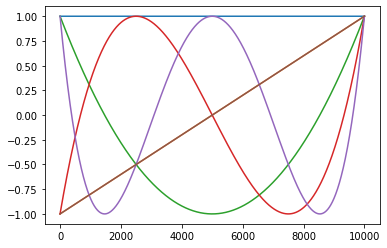

In [50]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy

def TnFactory(n,x):
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return (2*x*TnFactory(n-1,x) - TnFactory(n-2,x))
    
array = np.linspace(-1, 1, num=10000)

t_0 = [TnFactory(0,x) for x in np.nditer(array)] 
t_1 = [TnFactory(1,x) for x in np.nditer(array)] 
t_2 = [TnFactory(2,x) for x in np.nditer(array)] 
t_3 = [TnFactory(3,x) for x in np.nditer(array)] 
t_4 = [TnFactory(4,x) for x in np.nditer(array)] 
t_5 = [TnFactory(1,x) for x in np.nditer(array)] 


plt.figure()
plt.plot(t_0, label = 'T0')
plt.plot(t_1, label = 'T1')
plt.plot(t_2, label = 'T2')
plt.plot(t_3, label = 'T3')
plt.plot(t_4, label = 'T4')
plt.plot(t_5, label = 'T5')
plt.show()

# Week 11: Networks 3 (epidemiology)


While researchers have been modeling the spread of diseases and information for many years, the COVID-19 pandemic playing out right now puts a new emphasis on the importance of being able to model (and thus predict) how diseases propagate through populations. So how do you most effectively model the spread of a disease? There are many^ ways, and all of them (at least the useful ones) involves networks. In this notebook you will get your hands on a couple different modeling approaches. Specifically:

* Spreading processes on static networks
* Spreading processes on temporal networks
* Metapopulation models

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx
import netwulf as nw
import numpy as np
import pandas as pd
from tqdm import trange

## Exercises

In a *contact network* nodes are people and links represent interactions that can happen between people. You can use such a network as a *substrate* for simulating the spreading of "something". Spreading of what? That's up to you. It can be a disease, a behavior, a piece of information, anything you can imagine people may pass along. There's a whole subfield of Network Science which deals with this, but the fundamental idea is actually quite simple:

> Nodes that are connected can transmit this "something" with a probability. Each timestep of the simulation is an opportunity for the "something" to spread.

You can then make this more nuanced by adding extra criteria for transmission. For disease modeling these can e.g. be that nodes can only be infected after multiple exposures or if multiple neighbors are infected, that they can be cured and become resistant/susceptible with some probability, that they may die and exit the simulation creating a void in the network, that becoming infected makes them change their links, that godzilla walks in and eats everyone—the possibilities are endless and you decide which rules exist in the simulation universe.

Generally speaking, there are four major classes of so-called "compartmental models" in network epidemiology:
* **Susceptible-Infected (SI)**: Nodes are susceptible at start, and once they are infected they never recover. This models spreading of unforgetable information, or diseases that people get and pass on, and never recover from (like HIV, herpes, etc.).
* **Susceptible-Infected-Susceptible (SIS)**: Nodes are susceptible, then get infected and stay infected for some time, then get susceptible again, an the cycle continues. This could model things like the flu which comes and goes and you get and recover from over and over again.
* **Susceptible-Infected-Resistant (SIR)**: Nodes become infected and after some time they gain resistance so that they can niether become infected nor spread disease/information further. Once they are resistant they are essentially "removed" from the network, so this type of model works for diseases where people recover and gain resistance as well as ones that kill people, as niether type of person can transmit (measles, chickenpox but also rabies, Creutzfeldt–Jakob disease, etc.).
* **Susceptible-Infected-Resistant-Susceptible (SIRS)**: Probably self-explanatory if you understood the above.

The idea that drives the "compartmenal" modeling approach is that within a population you can assign each
individual to a compartment based on their "state" (infected, susceptible, etc.). When you start the simulation,
individuals then flow between compartments with specific flow rates.

![img](https://upload.wikimedia.org/wikipedia/commons/9/93/SIR_Flow_Diagram.svg)

This then allows us to describe the flow of individuals between compartments (and thus the spreading of the disease)
using differential equations. For example in the simple SIR model shown above, the dynamics can be described with
three differential equations (one for each compartment). They each tell us how fast the population in the corresponding
compartment it changing:

$$\frac{dS}{dt} = -\beta SI$$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

So at a given point in time how many people are leaving the susceptible compartment and entering the Infected compartment?
Well that's simply the the number of susceptible $S$ times the number of infected $I$ multipled with some disease-specific constant $\beta$.

And what's the growth in the number of infected? Easy! It's just the number of people coming in from the susceptible compartment $\beta SI$ minus all the people leaving for the "Recovered" compartment $\gamma I$, where gamma is some constant that describs how fast people recover.

And the rate at which people enter the recovered state? If you understood the above you can explain this to yourself.

**That's it!**. That's how all compartmental models work!

> **Ex. 11.1.1**: But as I wrote above there are many different types of compartmental models. Write down the rate equations for the SIS model:
>
>![img](https://upload.wikimedia.org/wikipedia/commons/c/cb/SIS_compartment_model.svg)
>
> Follow the reasoning in the example for the SIR model above. Answer the following:
* how many equations you need if there are two compartments.
* What specifically does each equation describe?
* What do $\beta$ and $\gamma$ intuitively describe? What can you say about a disease with a really big $\gamma$? Or a really small $\gamma$? How about big or small $\beta$?

> **Ex. 11.1.1 Answer:**
* We will need two equations.
* One will describe the movemoent from Succeptible to Infectious, and one will describe the opposite route.
* Intuitively, $\beta , \gamma$ describe the probability of getting sick, and getting better accordingly. if a disease with a really $\beta$ would make it very infecious (and vice versa), and a really high $\gamma$ would indicate a very deadly disease (and vice versa).

> **Ex. 11.1.2** (optional): If you really understood the above, you should have no trouble writing down the equations for a SIRS
model. Go ahead and try. Hint: You will need to introduce a new constant that describes the rate at which people move from R to S.

> **Ex. 11.1.3**: Professor of physics and mathematic and all around cool guy, Dirk Brockmann,
makes interactive articles called *Explorables* that introduce ideas in Complexity science. Read/play with
[his explorable](http://www.complexity-explorables.org/explorables/neighbors/) on targeted vaccination to mitigate epidemic spreading in the real world and answer the
following questions:
> 1. In the BA network, roughly what percentage of the population do you have to vaccinate with **strategy A** to only get around 10
infected individuals? What about **startegy B** and **strategy C**?
> 2. **strategy A** and **strategy C** are both entirely random, but one is much more effective than the other. Explain
why. What clever idea is **strategy C** employing?
> 3. Why is this effect larger in the BA network than in the ER network?

> **Ex. 11.1.3 Answer:**
1. For Strtegy A, around 80% would make the Average number of infected people around 20. For stratefy B, the required number is as little as 17.7%. For Strategy C around 50% is required (though the variance is quite high).
2. Despite **Strategy A** and **Strategy C** being compeltely random, **Strategy C** is cleverly using the fact that by randomly picking a neighbor of the randomly picked node, we are more likely to choose a highly connected nodes (as it has more connections for us to randomly encounter). Thus, we are more likely to give the vaccine to a highly connected person (**Strategy B**)
3. A BA network tends to have more links to begin with, thus the likelyhood of randomly choosing a well-connected node is event greater and thus the strategy is more effective.

> **Ex. 11.1.4**: Choose one of these two explorables ([1](http://www.complexity-explorables.org/explorables/herd/) or [2](http://www.complexity-explorables.org/explorables/epidemonic/)) read/play with and understand it, and explain in your own words what phenomenon it communicates.

> **Ex. 11.1.4 Answer:** Link 1 explains the concept of Heard Immunity: That if enough people in a community are vaccinated against a disease, the entire community can be free of that disease even without having 100% vaccincation (the rate of vaccination required of course differs based on the Transmissibility of the disease and in real life probably on some other factors as well). Heard Immunity works by essentially 'blocking' the interaction of infected people with people that are not immune. Since the disease can spread only if there is a link between a sick and a susceptible person, the more vaccinated people there are, the less connections there are between sick and susceptible people. When there are enough vaccinted people, no possible links between sick and susceptible person can form and thus heard immunity is achieved. 

> **Ex. 11.1.5**: The simplest compartmental model is the *SI* model. Below I have implemented a simulation of such a model.
You can see in line 5 that I initialize all nodes in the *S* compartment, but after running, all nodes are in the *I* compartment.
Does this make sense to you?
1. Comment the code abundantly, explaining what's happing at each step.
2. Adapt the code and make a plot of the fraction of infected over time. You may have to restart it a couple of time to make sure patient 0 is someone connected to the rest of the population.
3. Extend the code such after a variable number of timesteps `T_I` infected nodes become susceptible again. Set `T_I = 10` to begin with and plot the fraction of infected over time for 200 timesteps. Does the result make sense? Comment on what you see.

In [2]:
G = nx.connected_caveman_graph(10, 5)
#nw.visualize(G) # Uncomment if you want to have a look at the network

In [3]:
## Ex 11.1.5.1 - strictly commented version: 
p_I = 0.1 #is the pre-set (exogenous) probability of infection from one person to another
n_iter = 200 # how many time periods we have in the model

I = set() # will recieve our sick nodes that accumulate over time
S = set(G.nodes()) #gives an ordered set of unique items. will help make sure we don't re-iterate already infected nodes as we get more of those over the priods.

patient0 = np.random.choice(list(S)) # randomly pick a node that will represent patient zero

I.add(patient0) #add patient zero to our list of infected nodes
S.remove(patient0) # remove patient zero from our list of susceptible nodes

for t in range(n_iter): # each iteration here is a period. So in each period: 
    for infected_node in list(I): #iterate over each sick node in the list of infected nodes
        neighbors = G.neighbors(infected_node) #get all the linked nodes of the given infected node
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) 
        # infect the neighbor if randomly chosen number is smaller than the exoegnous probability we set
        I |= infected_neighbors # add the newly infected neighbors to the set of infected nodes
        S -= infected_neighbors # remove the newly infected nodes from the set of susceptible nodes (because they are sick now)

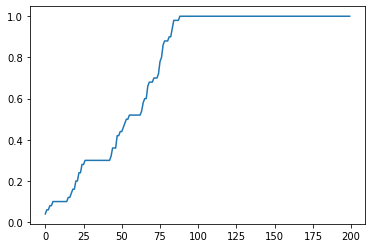

In [4]:
# Ex. 11.1.5.2 
p_I = 0.1
n_iter = 200 

I = set()
S = set(G.nodes()) 
patient0 = np.random.choice(list(S)) 

I.add(patient0) 
S.remove(patient0)

ratio = []

for t in range(n_iter): 
    for infected_node in list(I): 
        neighbors = G.neighbors(infected_node) 
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) 
        I |= infected_neighbors
        S -= infected_neighbors 
    ratio.append((len(I) / (len(I) + len(S))))
        

plt.plot(ratio)

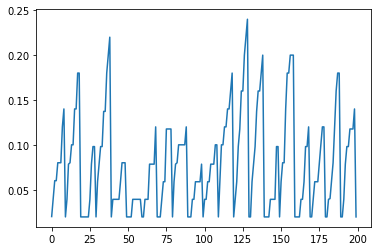

In [5]:
# Ex. 11.1.5.3
p_I = 0.1
n_iter = 200 
T_I = 10

I = set()
S = set(G.nodes()) 
patient0 = np.random.choice(list(S)) 

I.add(patient0) 
S.remove(patient0)

ratio = []

for t in range(1,n_iter+1): 
    if t % T_I == 0:
        for infected_node in list(I): 
            S = set(G.nodes())     
            I = set()
            I.add(np.random.choice(list(S)))
    else:
        for infected_node in list(I): 
            neighbors = G.neighbors(infected_node) 
            infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) 
            I |= infected_neighbors
            S -= infected_neighbors 
    ratio.append((len(I) / (len(I) + len(S))))
        

plt.plot(ratio)

> **Written answer to Ex.11.1.5.3:** This result makes sense to me. As we saw in the previous question, a model in which the ratio can only go up, after 10 periods the infection ratio was around 20%. In this model, where every 10th period we 'start fresh', we see the infection rate consistently climb to somewhere around 20% and then fall again.

> **Ex. 11.1.6**: Use what you have learned and implement an SIRS model.
* Run it on the Facebook network from last week (so load that into a `networkx.Graph`).
* Record the fraction of infected, susceptiple and recovered over time.
* After the simulation has run, plot these quantities over time and comment on your results
* Be proud of yourself for having solved a really interesting problem.

In [6]:
# Answer to Ex. 11.1.6
# Get FB network from previous ex:
data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

def func(data_t):
    # Subset of the pandas dataframe
    #data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # Create a `nx.DiGraph` from this dataframe
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)

    return G_t

G1 = nx.from_pandas_edgelist(data, 'user1', 'user2')

100%|██████████| 200/200 [00:36<00:00,  5.05it/s]


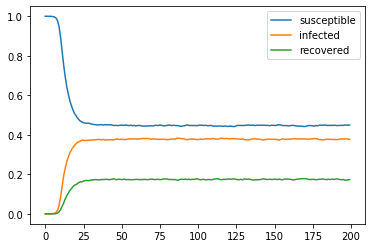

In [24]:
G2 = G1.copy()
p_I = 0.1
p_R = 0.2
p_S = 0.3
n_iter = 200 

I = set()
R = set()
S = set(G2.nodes()) 
patient0 = np.random.choice(list(S)) 

I.add(patient0) 
S.remove(patient0)

infected = []
recovered = []
susceptible = []

for t in trange(n_iter): 
    for infected_node in list(I):  # from S to I
        neighbors = G2.neighbors(infected_node) 
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) 
        I |= infected_neighbors
        S -= infected_neighbors 
    
    for i in list(I): # from I to R
        if np.random.random() < p_R:
            recovered_node = i
            R.add(recovered_node)
            I.discard(recovered_node) 

    for r in list(R): # from R to S
        if np.random.random() < p_S:
            susceptible_node = r
            S.add(susceptible_node)
            R.discard(susceptible_node)            

    susceptible.append(len(S) / (len(S) + len(I) + len(R)))
    infected.append(len(I) / (len(S) + len(I) + len(R)))
    recovered.append(len(R) / (len(S) + len(I) + len(R)))
    

plt.figure()
plt.plot(susceptible, label = 'susceptible')
plt.plot(infected, label = 'infected')
plt.plot(recovered, label = 'recovered')
plt.show()


## Further Learning

Since the above exercises teaches you how to write down epidemic models (as systems of differential equations)
and subsequently teaches you how to simulate a spreading process on a network to obtain data on infected/susceptible/recovered
over time, you would think it natural that I also taught you how to fit these epidemic models to such data.
This, however, is going a bit too far as this is not a course in computational epidemiology. But if you want to
figure out how to do it, you literally just need to Google search for "fit SIR model".

And finally, a note on how these models are used in the real world. The state-of-the-art in epidemiological modeling is something called "meta popultion models". They are essentially systems of compartmental models. One component in such a model may be a country, and it has its own little SI, SIR or SIRS model. Components are then coupled because there are people moving between them. The paper *The Hidden Geometry of Complex,
Network-Driven Contagion Phenomena* by Dirk Brockmann and Dirk Helbing published in Science in 2013 ([link here](https://www.dropbox.com/s/hxprfyr51fwh907/brockmann13.pdf?dl=0)) sets up such a model for the world using airline traffic as a proxy for people flow between countries. It is a must read if you
are curious about how the pros predict things like when a disease will arrive in a certain place or where a disease originated. I strongly recommend reading it and understanding the figures, it is a stroke of genius.